In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from collections import deque
import numpy as np
import cv2
import os
import glob
%matplotlib inline

Shape of Images: (720, 1280, 3)


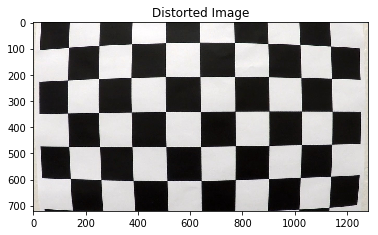

In [2]:
# Calibration Images Reading

allImages = []

#Read all Calibration Images
allImageNames = glob.glob('camera_cal/calibration*.jpg')

for imgName in allImageNames:
    im = mpimg.imread(imgName)
    allImages.append(im)

distortedImage = allImages[0]
shapeOfImgs = distortedImage.shape
print("Shape of Images:",shapeOfImgs)
plt.title("Distorted Image")
plt.imshow(distortedImage)

In [3]:
#Object and Image Point Initializations
vert = 9
horiz = 6

objPoints = [] # 3D points
imgPoints = [] # 2D points

objP = np.zeros((vert*horiz,3),np.float32)
objP[:,:2] = np.mgrid[0:vert,0:horiz].T.reshape(-1,2)

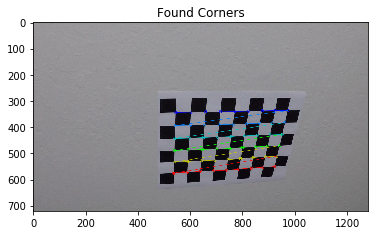

In [4]:
#Find Corners
firsIm = True
for img in allImages:
    grayIm = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayIm, (vert,horiz), None)
    if ret:
        imgPoints.append(corners)
        objPoints.append(objP)
        if firsIm:
            drwImg = cv2.drawChessboardCorners(img, (vert,horiz),corners, ret)
            firsIm = False
plt.title("Found Corners")
plt.imshow(drwImg,cmap='gray')

In [5]:
# Camera calibration

print('Number of Found Images: ',len(objPoints)) # Some Images does not contain 9x6 corners

imShape = shapeOfImgs[0:2][::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imShape[::-1], None, None)

Number of Found Images:  17


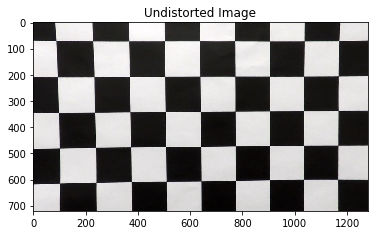

In [6]:
# Undistort Images
dst = cv2.undistort(distortedImage, mtx, dist, None, mtx)
plt.title('Undistorted Image')
plt.imshow(dst)

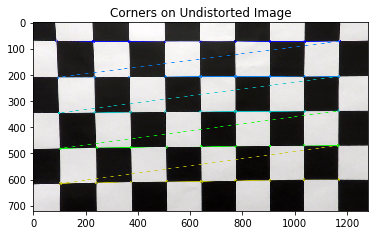

In [7]:
dstGray = cv2.cvtColor(dst,cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(dstGray, (9,5), None)
drwImg = cv2.drawChessboardCorners(dst, (9,5),corners, ret)
plt.title('Corners on Undistorted Image')
plt.imshow(drwImg)

In [8]:
print("Camera Matrix:")
print(mtx)
print()
print("Distortion Coefficients:")
print(dist)

Camera Matrix:
[[1.15662906e+03 0.00000000e+00 6.69041438e+02]
 [0.00000000e+00 1.15169194e+03 3.88137239e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
[[-0.23157149 -0.1200054  -0.00118338  0.00023305  0.15641575]]


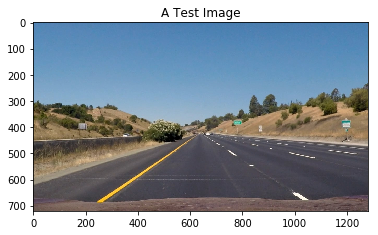

In [9]:
# Upload Test Images

testImages = []

#Read all Test Images
allTestImageNames = glob.glob('test_images/*.jpg')

for imgName in allTestImageNames:
    im = mpimg.imread(imgName)
    testImages.append(im)

aTestImage = testImages[0]
plt.title('A Test Image')
plt.imshow(aTestImage)   

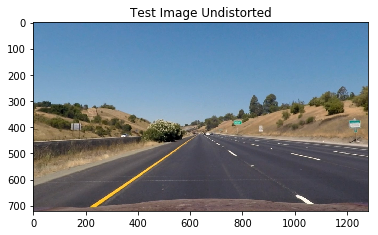

In [10]:
undistortImg = cv2.undistort(aTestImage, mtx, dist, None, mtx)
plt.title('Test Image Undistorted')
plt.imshow(undistortImg)   

In [11]:
def converToHLS(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS);

def converToHSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV);

In [12]:
def getLane(image, sobelThres=(30,100) , W = True, Y = True):
    #cv2.inRange function derives the wanted colors between two upper and lower limit

    LOWER_WHITE_THRES = [0,200,0]
    HIGHER_WHITE_THRES = [255,255,255]
    
    LOWER_YELLOW_THRES = [20, 80, 80]
    HIGHER_YELLOW_THRES = [30, 255, 255]
    
    #White
    hlsImage = converToHLS(image);
    hsvImage = converToHSV(image);
    
    L = hlsImage[:,:,1]

    #Sobel Operation
    sobX = cv2.Sobel(L, cv2.CV_64F, 1, 0)
    abSobX = np.absolute(sobX)
    scalSobel = np.uint8(255*abSobX/np.max(abSobX))
    
    sobelBin = np.zeros_like(scalSobel)
    sobelBin[(scalSobel >= sobelThres[0]) & (scalSobel <= sobelThres[1])] = 255
       
    # HLS is better at finding white Images
    lowerWhite = np.array(LOWER_WHITE_THRES, dtype=np.uint8) ## HLS -> L brighness
    higherWhite = np.array(HIGHER_WHITE_THRES, dtype=np.uint8)
    whiteMask = cv2.inRange(hlsImage, lowerWhite, higherWhite)

    # HSV is better at finding Yellow Images
    lowerYellow = np.array(LOWER_YELLOW_THRES, dtype=np.uint8)
    higherYellow = np.array(HIGHER_YELLOW_THRES, dtype=np.uint8)
    yellowMask = cv2.inRange(hsvImage, lowerYellow, higherYellow)

    if W and Y:
        whiteYellowCombiMask =  cv2.bitwise_or(whiteMask, yellowMask, sobelBin)
        combiImage = cv2.bitwise_and(image, image, mask=whiteYellowCombiMask)
    elif Y:
        combiImage = cv2.bitwise_and(image, image, mask=yellowMask)
    elif W:
        combiImage = cv2.bitwise_and(image, image, mask=whiteMask)
    else:
        combiImage = image

    return combiImage

In [13]:
LEFT_ROI = 0.095
RIGHT_ROI = 0.96
MIDDLE_LEFT_ROI = 0.47
MIDDLE_RIGHT_ROI = 0.55
MIDDLE_HEIGHT_ROI = 0.59

def region_of_interest(img):

    xDim = img.shape[1]
    yDim = img.shape[0]

    left = [int(xDim * LEFT_ROI), yDim - 1]
    right = [int(xDim * RIGHT_ROI), yDim - 1]
    middle_rigth = [int(xDim * MIDDLE_RIGHT_ROI), int(yDim * MIDDLE_HEIGHT_ROI)]
    middle_left = [int(xDim * MIDDLE_LEFT_ROI), int(yDim * MIDDLE_HEIGHT_ROI)]

    allCoordinates = [left, right, middle_rigth, middle_left]
    vertices = np.array([allCoordinates], dtype=np.int32)

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [14]:
def undistortImg(img):
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)
    return undistImg

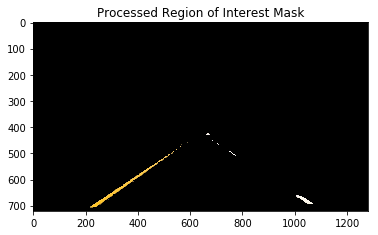

In [15]:
undisImg = undistortImg(aTestImage)            # Undistort
processedIm =  getLane(undisImg)               # Masking
roiImg = region_of_interest(processedIm)       # ROI
plt.title('Processed Region of Interest Mask')
plt.imshow(roiImg)

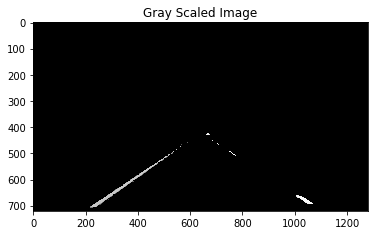

In [16]:
imgGray = cv2.cvtColor(roiImg, cv2.COLOR_RGB2GRAY) # Single Channel Image
plt.title('Gray Scaled Image')
plt.imshow(imgGray,cmap='gray')

In [17]:
def showRegionOfInterest(image, vertices):

    x, y = [], []
    for ver in vertices:
        x = x + [ver[0]]
        y = y + [ver[1]]

    x = x + [vertices[0][0]]
    y = y + [vertices[0][1]]

    plt.imshow(image)
    plt.plot(x, y, 'b--', lw=2)
    plt.title('Road Flatness Measuring')
    plt.show()

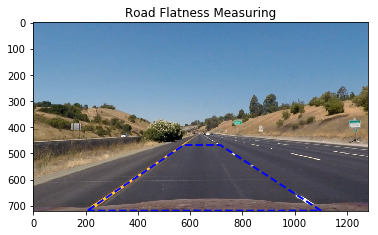

In [18]:
# Lets Select Road flatness parameters
LEFT = 0.20
RIGHT = 0.82
MIDDLE_LEFT = 0.42
MIDDLE_RIGHT = 0.55
MIDDLE_HEIGHT_FLAT = 0.65

xDim = imgGray.shape[1]
yDim = imgGray.shape[0]

left_point = [207, yDim - 1]
right_point = [xDim -180, yDim - 1]
middle_rigth_point = [xDim -565, int(yDim * MIDDLE_HEIGHT_FLAT)]
middle_left_point = [575, int(yDim * MIDDLE_HEIGHT_FLAT)]

showRegionOfInterest(undisImg, [left_point,right_point,middle_rigth_point,middle_left_point])

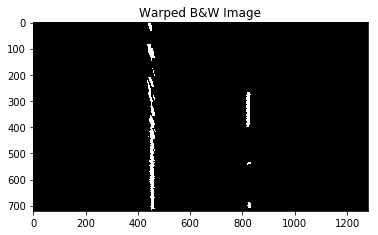

In [37]:
# Perspective Transform
def getWarpedImg(img,reverse=False):
    src = np.float32([
                      middle_left_point,   # Mid Left
                      middle_rigth_point,  # Mid Right
                      left_point,          # Left
                      right_point          # Right
                     ])

    dst = np.float32([
                      [455,0],          # middle Left 
                      [xDim-455,0],     # middle Rigth
                      [455,yDim],       # Left
                      [xDim-455,yDim]   # Right    
                    ])  
    if reverse:
        M = cv2.getPerspectiveTransform(dst,src)
        warped = cv2.warpPerspective(img, M, (xDim,yDim), flags=cv2.INTER_LINEAR)
        return warped
    else:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, (xDim,yDim), flags=cv2.INTER_LINEAR)
        warped_bw = cv2.threshold(warped, 10, 255, cv2.THRESH_BINARY)[1]
    return warped_bw

warped_bw = getWarpedImg(imgGray)
plt.title('Warped B&W Image')
plt.imshow(warped_bw,cmap='gray')

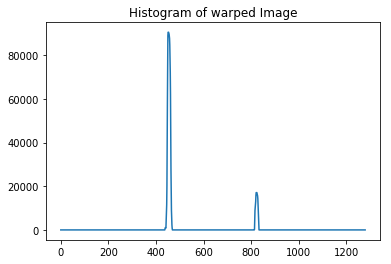

In [20]:
# Histogram of the Test Image
hist = np.sum(warped_bw[warped_bw.shape[0]//2:,:], axis=0)
plt.title('Histogram of warped Image')
plt.plot(hist)

In [21]:
MAX_LEN_QUE = 12 # Take last 12 Frame consider to calculate current Line measure
myQue = deque(maxlen=MAX_LEN_QUE)

def softenLanes(left_fitx, right_fitx):

    allLeft = np.zeros_like(left_fitx)
    allRight = np.zeros_like(right_fitx)

    myQue.append([left_fitx,right_fitx])

    for each in myQue:
        allLeft = [sum(x) for x in zip(allLeft, each[0])]
        allRight = [sum(x) for x in zip(allRight, each[1])]
         
    allLeftVar = np.array(allLeft) /  len(myQue)
    allRightVar = np.array(allRight) / len(myQue)

    left_fitx_soft = allLeftVar
    right_fitx_soft = allRightVar

    return left_fitx_soft, right_fitx_soft

In [22]:
#Global Variables for line parameters from one last frame, used in case no line detected in the current frame
Glefty = np.array([])
Gleftx = np.array([])
Grighty = np.array([])
Grightx = np.array([])

In [23]:
def getPoly(imgBW, numWind = 5, showFoundPixels = False, showWindows=False, soften=True):
    
    # Create a 3 Channel Empty Image for visualization
    out_img = np.dstack((imgBW, imgBW, imgBW))*255

    xDim = imgBW.shape[1]
    yDim = imgBW.shape[0]

    midpoint = np.int(xDim/2)                            # Middle point xDim/2
    leftx_base = np.argmax(hist[:midpoint])              # Left point -> Max stack of white pixel w.r.t x axis -> (0:640)
    rightx_base = np.argmax(hist[midpoint:]) + midpoint  # Right point -> Max stack of white pixel w.r.t x axis -> (640:1280)

    # Choose the number of sliding windows
    nwindows = numWind

    # Set height of windows
    window_height = np.int(yDim/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = imgBW.nonzero() # Returns the coordinates of non-zero Pixels -> [[x1,x2,x3,...],[y1,y2,y3,...]]
    nonzeroy = np.array(nonzero[0]) # Seperate Coordinates
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base   # init x position of left window
    rightx_current = rightx_base # init x position of right window
    
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = yDim - (window+1) * window_height
        win_y_high = yDim - window * window_height
        
        # Coordinates of Rectangular corners
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if showWindows:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window/ Filter pixels that are inside of window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    global Glefty
    global Gleftx
    global Grighty
    global Grightx
    
    if lefty.size and leftx.size: # For Challange Videos Empty Polynomial Checker
        left_fit = np.polyfit(lefty, leftx, 2)
        Glefty = lefty
        Gleftx = leftx
    else:
        left_fit = np.polyfit(Glefty, Gleftx, 2)
    
    if righty.size and rightx.size:
        right_fit = np.polyfit(righty, rightx, 2)
        Grighty = righty
        Grightx = rightx
    else:
        right_fit = np.polyfit(Grighty, Grightx, 2)
    
    # Visualise   
    ploty = np.linspace(0, yDim-1,yDim) # Linear Line from 0 -> 719 & Amount 720
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # Fit the left linear line with Polynomial Parameter
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] # Fit the right linear line with Polynomial Parameter

    if (showFoundPixels):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if (soften):
        left_fitx_soft, right_fitx_soft = softenLanes(left_fitx, right_fitx)
        return out_img, left_fitx_soft, right_fitx_soft, ploty
    else:    
        return out_img, left_fitx, right_fitx, ploty

(720, 0)

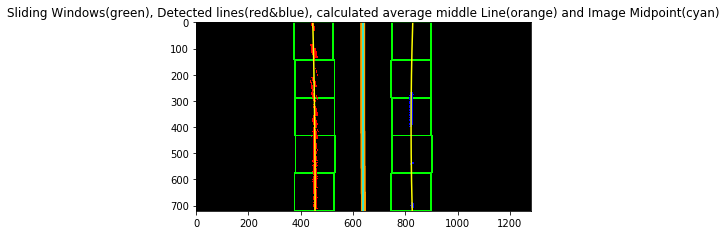

In [24]:
out_img, left_fitx, right_fitx, ploty = getPoly(warped_bw,showFoundPixels = True, showWindows=True, soften=True)
ploty = np.linspace(0, yDim-1,yDim) # Linear Line from 0 -> 719 & Amount 720 Array: [0,1,2,3,4,...,719]
plt.title('Sliding Windows(green), Detected lines(red&blue), calculated average middle Line(orange) and Image Midpoint(cyan)')
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.plot(((left_fitx + right_fitx)//2), ploty, color='orange',linewidth=5) # Lane Middle
plt.plot(np.full((yDim,1),xDim/2), ploty, color='cyan')         # Image Middle
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [25]:
MAX_LEN_CURV_QUE = 6
myQueCur = deque(maxlen=MAX_LEN_CURV_QUE)

ym_per_pix = 17/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension -> Road Flatness Measuring image above width of the lane

def calculateCurvature(midPol): 
    xCor = np.float32([i[0] for i in midPol])
    yCor = np.float32([i[1] for i in midPol])

    y_eval = np.max(yCor)

    fit = np.polyfit(yCor,xCor, 2)
    curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    
    fit_cr = np.polyfit(ploty*ym_per_pix, xCor*xm_per_pix, 2)
    curverad_meter = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    myQueCur.append(curverad_meter)    
    curverad_meter = sum(myQueCur) /  len(myQueCur)
    
    return curverad_meter

In [26]:
def calculateDeviation(midPol,midXLen,midYlen):
    return (midXLen - midPol[int(midYlen)][0])*xm_per_pix

In [27]:
def unWarpLanes(UNDIST_Img,left_fitx, right_fitx, ploty, drawLines=False): ## Function name change -> processLaneInfo
    
    xDim = UNDIST_Img.shape[1]
    yDim = UNDIST_Img.shape[0]
    
    lane_img = np.zeros((yDim, xDim, 3), dtype=np.uint8)

    leftPol = np.column_stack((left_fitx,ploty))
    leftPol = np.array(leftPol, dtype=np.int32)

    rightPol = np.column_stack((right_fitx,ploty))
    rightPol = np.array(rightPol, dtype=np.int32)
    
    if drawLines:
        cv2.polylines(lane_img, [leftPol], False, (255,0,0),thickness=13)
        cv2.polylines(lane_img, [rightPol], False, (0,0,255),thickness=13)
   
    allCoordinates = [np.append(leftPol, rightPol[::-1], axis=0)] 
    vertices = np.array([allCoordinates], dtype=np.int32)
    
    #polygon fit
    cv2.fillPoly(lane_img, vertices, (0,255,0))
    
    # Lane Middle
    midPol = (rightPol+leftPol)//2
    cv2.polylines(lane_img, [midPol], False, (0,255,255),thickness=5)
    
    culv = calculateCurvature(midPol)
    dev = calculateDeviation(midPol,UNDIST_Img.shape[1]/2,UNDIST_Img.shape[0]/2) 
    
    lane_img = getWarpedImg(lane_img,reverse=True)
    
    if culv < 2000:
        strCur = 'Radius of Curvature: ' + str(round(culv, 2)) + 'm'
    else:
        strCur = 'Radius of Curvature: Straight'
    strDev = 'Vehicle is off center by: ' + str(round(dev, 2)) + 'm'
    
    cv2.putText(lane_img,strCur,(25,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(211,211,211),2,cv2.LINE_AA)
    cv2.putText(lane_img,strDev,(25,85), cv2.FONT_HERSHEY_SIMPLEX, 1,(211,211,211),2,cv2.LINE_AA)
 
    comboImage = cv2.addWeighted(lane_img, 0.3, UNDIST_Img, 1., 0.)
    
    return comboImage

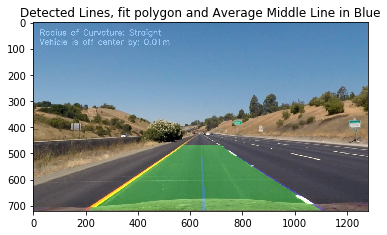

In [28]:
plt.title('Detected Lines, fit polygon and Average Middle Line in Blue')
plt.imshow(unWarpLanes(undisImg,left_fitx, right_fitx, ploty,drawLines=True))

In [29]:
def myPipeLine(img):
    undDisImg = undistortImg(img)   
    proImg = getLane(undDisImg)
    roiImg = region_of_interest(proImg)
    imgGray = cv2.cvtColor(roiImg, cv2.COLOR_RGB2GRAY)
    warpImg = getWarpedImg(imgGray)
    out_img, left_fitx, right_fitx, ploty = getPoly(warpImg,showFoundPixels = True, showWindows=True, soften=True)
    comboImage = unWarpLanes(undDisImg,left_fitx, right_fitx, ploty)
    #comboImage = unWarpLanes(out_img,left_fitx, right_fitx, ploty) #np.dstack((warpImg,warpImg,warpImg)) # Test
    return comboImage

In [30]:
if False:
    myQue.clear()
    myQueCur.clear()
    clip1 = VideoFileClip("project_video.mp4")
    my_clip = clip1.fl_image(myPipeLine)
    %time my_clip.write_videofile('project_video_output.mp4', audio=False)

In [31]:
if False:
    myQue.clear()
    myQueCur.clear()
    clip1 = VideoFileClip("harder_challenge_video.mp4")
    my_clip = clip1.fl_image(myPipeLine)
    %time my_clip.write_videofile('harder_challenge_video_output.mp4', audio=False)

In [32]:
if False:
    myQue.clear()
    myQueCur.clear()
    clip1 = VideoFileClip("challenge_video.mp4")
    my_clip = clip1.fl_image(myPipeLine)
    %time my_clip.write_videofile('challenge_video_output.mp4', audio=False)

In [33]:
#ffmpeg_extract_subclip("project_video.mp4", 47, 50, targetname="project_video_last.mp4")

In [34]:
#clip1 = VideoFileClip("challenge_video.mp4")
#clip1.save_frame("TestChallende.jpg", t=1)